## HW3: Decision Tree, AdaBoost and Random Forest
In hw3, you need to implement decision tree, adaboost and random forest by using only numpy, then train your implemented model by the provided dataset and test the performance with testing data

Please note that only **NUMPY** can be used to implement your model, you will get no points by simply calling sklearn.tree.DecisionTreeClassifier

## Load data
The dataset is the Heart Disease Data Set from UCI Machine Learning Repository. It is a binary classifiation dataset, the label is stored in `target` column. **Please note that there exist categorical features which need to be [one-hot encoding](https://www.datacamp.com/community/tutorials/categorical-data) before fit into your model!**
See follow links for more information
https://archive.ics.uci.edu/ml/datasets/heart+Disease

In [2]:
import pandas as pd
import numpy as np
file_url = "http://storage.googleapis.com/download.tensorflow.org/data/heart.csv"
df = pd.read_csv(file_url)

train_idx = np.load('train_idx.npy')
test_idx = np.load('test_idx.npy')

train_df = df.iloc[train_idx]
test_df = df.iloc[test_idx]

In [3]:
train_df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
136,54,1,2,192,283,0,2,195,0,0.0,1,1,reversible,0
232,58,0,4,170,225,1,2,146,1,2.8,2,2,fixed,1
233,56,1,2,130,221,0,2,163,0,0.0,1,0,reversible,0
184,46,1,4,120,249,0,2,144,0,0.8,1,0,reversible,0
84,55,0,2,135,250,0,2,161,0,1.4,2,0,normal,0


In [4]:
print(train_df.to_numpy().shape[1])

14


## Question 1
Gini Index or Entropy is often used for measuring the “best” splitting of the data. Please compute the Entropy and Gini Index of provided data. Please use the formula from [page 5 of hw3 slides](https://docs.google.com/presentation/d/1kIe_-YZdemRMmr_3xDy-l0OS2EcLgDH7Uan14tlU5KE/edit#slide=id.gd542a5ff75_0_15)

In [5]:
def gini(sequence, weights=None):
    # the smaller, the purer
    values, counts = np.unique(sequence, return_counts=True)
    if weights is None:
        probs = counts / len(sequence)
    elif len(weights) == 0 or np.all(weights == weights[0]):
        probs = counts / len(sequence)
    else:
        probs = []
        for v in values:
            idxs = np.where(sequence==v)[0]
            probs.append(sum(weights[idxs]))
    
    return 1 - sum(p*p for p in probs)

def entropy(sequence, weights=None):
    # the smaller, the purer
    values, counts = np.unique(sequence, return_counts=True)
    if weights is None:
        probs = counts / len(sequence)
    elif len(weights) == 0 or np.all(weights == weights[0]):
        probs = counts / len(sequence)
    else:
        probs = []
        for v in values:
            idxs = np.where(sequence==v)[0]
            probs.append(sum(weights[idxs]))
            print(v, idxs)
        print(probs)
    return -sum(p*np.log2(p) for p in probs)

In [6]:
# 1 = class 1
# 2 = class 2
data = np.array([1,2,1,1,1,1,2,2,1,1,2])

In [7]:
print("Gini of data is ", gini(data))

Gini of data is  0.4628099173553719


In [8]:
print("Entropy of data is ", entropy(data))

Entropy of data is  0.9456603046006401


## Question 2
Implement the Decision Tree algorithm (CART, Classification and Regression Trees) and trained the model by the given arguments, and print the accuracy score on the test data. You should implement two arguments for the Decision Tree algorithm
1. **criterion**: The function to measure the quality of a split. Your model should support `gini` for the Gini impurity and `entropy` for the information gain. 
2. **max_depth**: The maximum depth of the tree. If `max_depth=None`, then nodes are expanded until all leaves are pure. `max_depth=1` equals to split data once


In [9]:
def accuracy_score(ytest: np.ndarray, ypred: np.ndarray):
    return np.sum(np.equal(ytest, ypred)) / len(ytest)

In [10]:
def split(X: np.ndarray, y: np.ndarray, threshold: int, feature_idx=None, weights=None):
    if feature_idx != None:
        splitpoint = X[:, feature_idx] <= threshold
    else:
        splitpoint = X <= threshold
    # split X, y
    Xleft, yleft = X[splitpoint], y[splitpoint]
    Xright, yright = X[~splitpoint], y[~splitpoint]
    # split w
    if weights is not None:
        wleft, wright = weights[splitpoint], weights[~splitpoint]
    else:
        wleft, wright = None, None
    
    return Xleft, Xright, yleft, yright, wleft, wright

In [11]:
class Node:
    def __init__(self, impurity, amount, predicted):
        self.impurity = impurity
        self.amount = amount
        self.predicted = predicted
        self.feature_idx = -1
        self.threshold = 0
        self.left = None
        self.right = None

In [105]:
class DecisionTree():
    def __init__(self, criterion='gini', max_depth=None, random_best_split=False):
        self.criterion = criterion
        self.max_depth = max_depth
        self.random_best_split = random_best_split
        self.root = None # root node of the tree
        # choose criterion function
        if self.criterion not in ['gini', 'entropy']:
            raise TypeError('criterion')
        self.impurity = gini if self.criterion == 'gini' else entropy

        return None

    def __repr__(self):
        return f'DecisionTree(criterion={self.criterion}, max_depth={self.max_depth})'

    def print_tree(self, cur: Node):
        if cur == None:
            return
        print(cur.feature_idx, cur.threshold)
        self.print_tree(cur.left)
        self.print_tree(cur.right)

    def _best_split_1(self, X: np.ndarray, y:np.ndarray, weights=None):
        # initial
        feature_idx = -1
        threshold = None
        min_impure = 1 # set to max possible value
        # random attributes if true
        attr_idxs = np.arange(X.shape[1])
        if self.random_best_split:
            attr_size = np.random.randint(X.shape[1])
            attr_idxs = np.random.randint(X.shape[1], size=attr_size)
        # loop all features
        for i in attr_idxs:
            x = np.array(X[:, i]) # i-th column of X
            base = np.unique(x) # get unique values of  the column
            # loop all possible thresholds
            for j in range(len(base) - 1):
                # j-th threshold is the average of the j-th and (j+1)-th
                j_thre = (base[j]+base[j+1]) / 2
                # get split arrays
                _, _, yleft, yright, wleft, wright = split(x, y, threshold=j_thre, weights=weights)
                # calculate weighted average of the children
                impure_avg = (self.impurity(yleft, wleft)*(len(yleft)/len(y))) + (self.impurity(yright, wright)*(len(yright)/len(y)))
                # update
                if impure_avg < min_impure:
                    feature_idx = i
                    threshold = j_thre
                    min_impure = impure_avg
        # return
        return feature_idx, threshold

    def _best_split_2(self, X: np.ndarray, y:np.ndarray, weights=None):
        # initial
        feature_idx = -1
        threshold = None
        min_impure = 1 # set to max possible value
        # random attributes if true
        attr_idxs = np.arange(X.shape[1])
        if self.random_best_split:
            attr_size = np.random.randint(X.shape[1])
            attr_idxs = np.random.randint(X.shape[1], size=attr_size)
        # loop all features
        for i in attr_idxs:
            x = np.array(X[:, i]) # i-th column of X
            base = np.unique(x) # get unique values of  the column
            # loop all possible thresholds
            for j in base:
                # get split arrays
                _, _, yleft, yright, wleft, wright = split(x, y, threshold=j, weights=weights)
                # calculate weighted average of the children
                impure_avg = (self.impurity(yleft, wleft)*(len(yleft)/len(y))) + (self.impurity(yright, wright)*(len(yright)/len(y)))
                # update
                if impure_avg < min_impure:
                    feature_idx = i
                    threshold = j
                    min_impure = impure_avg
        # return
        return feature_idx, threshold

    def fit(self, X: np.ndarray, y: np.ndarray, sample_weight=None):
        # starts with the whole data
        self.root = self._grow(X, y, sample_weight)
        # calculate feature importance from nodes
        self.feature_importance = np.zeros(X.shape[1], int)
        self._calc_feature_importance(self.root)
        return self

    def _grow(self, X: np.ndarray, y:np.ndarray, weights: np.ndarray, depth=0):
        # empty node
        if X.size == 0:
            return None
        # create a node (calculate impurity with weights if needed)
        vals, cnts = np.unique(y, return_counts=True)
        node = Node(impurity=self.impurity(y, weights=weights), amount=len(y), predicted=vals[np.argmax(cnts)])
        # node is pure or reach max depth
        if node.impurity == 0:
            return node
        if (self.max_depth is not None) and (depth >= self.max_depth):
            return node
        # keep building tree, loop all features to find best partition
        feature_idx, threshold = self._best_split_2(X, y, weights)
        # split (exists better split)
        if feature_idx != -1:
            Xleft, Xright, yleft, yright, wleft, wright = split(X, y, threshold=threshold, feature_idx=feature_idx, weights=weights)
            node.feature_idx = feature_idx
            node.threshold = threshold
            # grow children
            node.left = self._grow(Xleft, yleft, wleft, depth+1)
            node.right = self._grow(Xright, yright, wright, depth+1)
        # return current node
        return node
    
    def predict(self, X: np.ndarray):
        if self.root == None:
            raise RuntimeError('fit the model first')
        ypred = []
        for datapoint in X:
            node = self.root
            while node.left != None and node.right != None:
                if node.feature_idx == -1:
                    break
                node = node.left if datapoint[node.feature_idx] <= node.threshold else node.right
            ypred.append(node.predicted)

        return ypred
    
    def _calc_feature_importance(self, node: Node):
        if node.feature_idx != -1:
            cur_level_fi = node.amount * node.impurity
            # decreased with children impurity * amount
            if node.left != None:
                left_fi = self._calc_feature_importance(node.left)
                cur_level_fi -= left_fi
            if node.right != None:
                right_fi = self._calc_feature_importance(node.right)
                cur_level_fi -= right_fi
            
            self.feature_importance[node.feature_idx] += cur_level_fi

            return node.amount * node.impurity

        return 0
    
    def get_feature_importance(self):
        if self.root == None:
            raise RuntimeError('fit the model first')
        return self.feature_importance

In [106]:
# transform values to numeric (thal)
train_df = train_df.replace({'thal': {'normal': 3, 'fixed': 6, 'reversible': 7}})
test_df = test_df.replace({'thal': {'normal': 3, 'fixed': 6, 'reversible': 7}})
# check rows with bad value
print(train_df['thal'].dtype)
print(test_df['thal'].dtype)

int64
int64


In [107]:
# split x, y and turn into numpy array
Xtrain = train_df.drop(columns=['target']).to_numpy()
ytrain = train_df['target'].to_numpy()
Xtest = test_df.drop(columns=['target']).to_numpy()
ytest = test_df['target'].to_numpy()

### Question 2.1
Using `criterion=gini`, showing the accuracy score of test data by `max_depth=3` and `max_depth=10`, respectively.


In [108]:
# get decision tree instance
clf_depth3 = DecisionTree(criterion='gini', max_depth=3)
# fit train data into model
clf_depth3 = clf_depth3.fit(Xtrain, ytrain)
# predict with test data
ypred = clf_depth3.predict(Xtest)
# calculate accuracy score and output (should be larger than 0.7)
print(f'Accuracy of {clf_depth3}:')
print(accuracy_score(ytest, ypred))

Accuracy of DecisionTree(criterion=gini, max_depth=3):
0.79


In [109]:
# get decision tree instance
clf_depth10 = DecisionTree(criterion='gini', max_depth=10)
# fit train data into model
clf_depth10 = clf_depth10.fit(Xtrain, ytrain)
# predict with test data
ypred = clf_depth10.predict(Xtest)
# calculate accuracy score and output (should be larger than 0.7)
print(f'Accuracy of {clf_depth10}:')
print(accuracy_score(ytest, ypred))

Accuracy of DecisionTree(criterion=gini, max_depth=10):
0.75


### Question 2.2
Using `max_depth=3`, showing the accuracy score of test data by `criterion=gini` and `criterion=entropy`, respectively.


- Note: Your decisition tree scores should over **0.7**. It may suffer from overfitting, if so, you can tune the hyperparameter such as `max_depth`
- Note: You should get the same results when re-building the model with the same arguments,  no need to prune the trees
- Hint: You can use the recursive method to build the nodes


In [110]:
# get decision tree instance
clf_gini = DecisionTree(criterion='gini', max_depth=3)
# fit train data into model
clf_gini = clf_gini.fit(Xtrain, ytrain)
# predict with test data
ypred = clf_gini.predict(Xtest)
# calculate accuracy score and output (should be larger than 0.7)
print(f'Accuracy of {clf_gini}:')
print(accuracy_score(ytest, ypred))

Accuracy of DecisionTree(criterion=gini, max_depth=3):
0.79


In [111]:
# get decision tree instance
clf_entropy = DecisionTree(criterion='entropy', max_depth=3)
# fit train data into model
clf_entropy = clf_entropy.fit(Xtrain, ytrain)
# predict with test data
ypred = clf_entropy.predict(Xtest)
# calculate accuracy score and output (should be larger than 0.7)
print(f'Accuracy of {clf_entropy}:')
print(accuracy_score(ytest, ypred))

Accuracy of DecisionTree(criterion=entropy, max_depth=3):
0.76


## Question 3
Plot the [feature importance](https://sefiks.com/2020/04/06/feature-importance-in-decision-trees/) of your Decision Tree model. You can get the feature importance by counting the feature used for splitting data.

- You can simply plot the **counts of feature used** for building tree without normalize the importance. Take the figure below as example, outlook feature has been used for splitting for almost 50 times. Therefore, it has the largest importance

![image](https://i2.wp.com/sefiks.com/wp-content/uploads/2020/04/c45-fi-results.jpg?w=481&ssl=1)

In [112]:
# only for plotting figures
import matplotlib.pyplot as plt

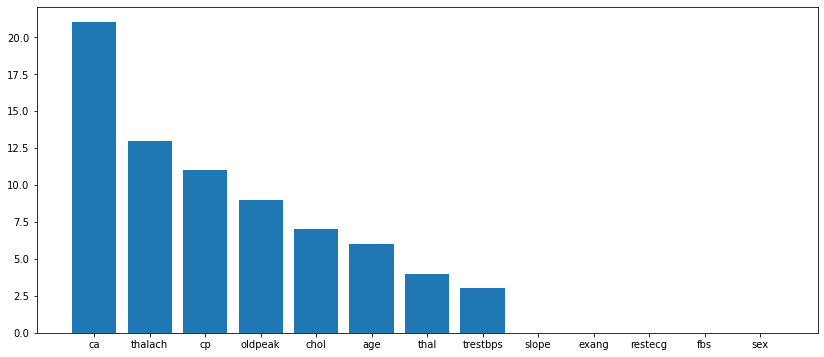

In [113]:
# using the model from question 2.1 with max depth = 10
feature_importance = clf_depth10.get_feature_importance()
feature_name = np.array(train_df.columns)
feature_name = feature_name[:len(feature_name)-1]
# sort
p = feature_importance.argsort()[::-1]
# plot
plt.figure(figsize=(14, 6))
plt.bar(feature_name[p], feature_importance[p])
plt.show()

## Question 4
implement the AdaBooest algorithm by using the CART you just implemented from question 2 as base learner. You should implement one arguments for the AdaBooest.
1. **n_estimators**: The maximum number of estimators at which boosting is terminated

In [114]:
class AdaBoost():
    def __init__(self, n_estimators):
        self.n_estimators = n_estimators
        self.strong_clf = None
        return None

    def __repr__(self):
        return f'AdaBoost(n_estimators={self.n_estimators})'

    def fit(self, X: np.ndarray, y_pretransform: np.ndarray):
        y = np.copy(y_pretransform)
        # turn target y into -1s and 1s if needed
        uniq = np.unique(y_pretransform)
        if not np.all(uniq==np.array([-1, 1])):
            y[y==0] = -1
        # initialize weight distribution
        weights = np.full(len(y), 1/float(len(y)))
        # store the fitted weak clfs
        self.strong_clf = []
        for _ in range(self.n_estimators):
            # fit weak classifier with sample weight
            weak_clf = DecisionTree(criterion='gini', max_depth=3)
            weak_clf = weak_clf.fit(X, y, sample_weight=weights)
            ypred = weak_clf.predict(X)
            # calculate weighted error (epsilon)
            diff = np.not_equal(y, ypred)
            idxs = np.where(diff == True)[0]
            weighted_error = sum(weights[idxs]) / sum(weights)
            # calculate alpha
            alpha = 0.5 * np.log((1-weighted_error)/float(weighted_error))
            # update weights (not normalized)
            weights = weights * np.exp(-alpha*y*ypred)
            # update strong clf
            self.strong_clf.append((alpha, weak_clf))
        
        return self

    def predict(self, X: np.ndarray):
        if self.strong_clf == None:
            raise RuntimeError('fit the model first')
        # initial ypred
        ypred = np.zeros(X.shape[0])
        # get predictions from strong clf
        for alpha, weak_clf in self.strong_clf:
            preds = weak_clf.predict(X)
            ypred += alpha*np.array(preds)
        ypred = np.sign(ypred).astype(int)
        # reset y values to original
        ypred[ypred==-1] = 0
        return ypred

### Question 4.1
Show the accuracy score of test data by `n_estimators=10` and `n_estimators=100`, respectively.


In [115]:
clf_10adaboost = AdaBoost(n_estimators=10)
clf_10adaboost = clf_10adaboost.fit(Xtrain, ytrain)
ypred = clf_10adaboost.predict(Xtest)
print(f'Accuracy of {clf_10adaboost}:')
print(accuracy_score(ytest, ypred))

Accuracy of AdaBoost(n_estimators=10):
0.79


In [116]:
clf_100adaboost = AdaBoost(n_estimators=100)
clf_100adaboost = clf_100adaboost.fit(Xtrain, ytrain)
ypred = clf_100adaboost.predict(Xtest)
print(f'Accuracy of {clf_100adaboost}:')
print(accuracy_score(ytest, ypred))

Accuracy of AdaBoost(n_estimators=100):
0.79


## Question 5
implement the Random Forest algorithm by using the CART you just implemented from question 2. You should implement three arguments for the Random Forest.

1. **n_estimators**: The number of trees in the forest. 
2. **max_features**: The number of random select features to consider when looking for the best split
3. **bootstrap**: Whether bootstrap samples are used when building tree


In [117]:
class RandomForest():
    def __init__(self, n_estimators, max_features, bootstrap=True, criterion='gini', max_depth=None):
        self.n_estimators = n_estimators
        self.max_features = max_features
        self.bootstrap = bootstrap
        self.criterion = criterion
        self.max_depth = max_depth
        self.trees = None
        return None

    def __repr__(self):
        return f'RandomForest(n_estimators={self.n_estimators}, max_features={self.max_features})'
    
    def fit(self, X: np.ndarray, y: np.ndarray, random_seed=None):
        # collect trees to become a forest
        self.trees = []
        # for every bootstrap dataset, build one decision tree
        np.random.seed(random_seed)
        for _ in range(self.n_estimators):
            # random sample index to build a bootstrap dataset
            idxs = np.random.randint(X.shape[0], size=X.shape[0])
            X_bootstrap, y_bootstrap = X[idxs], y[idxs]
            # decision tree instance
            tree_clf = DecisionTree(criterion=self.criterion, max_depth=self.max_depth, random_best_split=True)
            tree_clf = tree_clf.fit(X_bootstrap, y_bootstrap)
            self.trees.append(tree_clf)

        return self
    
    def predict(self, X: np.ndarray):
        if self.trees is None:
            raise RuntimeError('fit the model first')
        # initial ypred
        votes = []
        # get predictions from trees
        for tree_clf in self.trees:
            preds = tree_clf.predict(X)
            votes.append(preds)
        votes = np.array(votes)
        # get majority vote
        ypred = []
        for i in range(votes.shape[1]):
            vals, cnts = np.unique(votes[:, i], return_counts=True)
            ypred.append(vals[np.argmax(cnts)])

        return ypred

### Question 5.1
Using `criterion=gini`, `max_depth=None`, `max_features=sqrt(n_features)`, showing the accuracy score of test data by `n_estimators=10` and `n_estimators=100`, respectively.


In [118]:
clf_10tree = RandomForest(n_estimators=10, max_features=np.sqrt(Xtrain.shape[1]))
clf_10tree = clf_10tree.fit(Xtrain, ytrain, random_seed=11000)
ypred = clf_10tree.predict(Xtest)
accuracy_score(ytest, ypred)

0.8

In [119]:
clf_100tree = RandomForest(n_estimators=100, max_features=np.sqrt(Xtrain.shape[1]))
clf_100tree = clf_100tree.fit(Xtrain, ytrain, random_seed=12000)
ypred = clf_100tree.predict(Xtest)
accuracy_score(ytest, ypred)

0.82

### Question 5.2
Using `criterion=gini`, `max_depth=None`, `n_estimators=10`, showing the accuracy score of test data by `max_features=sqrt(n_features)` and `max_features=n_features`, respectively.


In [120]:
clf_random_features = RandomForest(n_estimators=10, max_features=np.sqrt(Xtrain.shape[1]))
clf_random_features = clf_random_features.fit(Xtrain, ytrain)
ypred = clf_random_features.predict(Xtest)
accuracy_score(ytest, ypred)

0.83

- Note: Use majority votes to get the final prediction, you may get slightly different results when re-building the random forest model

In [121]:
clf_all_features = RandomForest(n_estimators=10, max_features=Xtrain.shape[1])
clf_all_features = clf_all_features.fit(Xtrain, ytrain)
ypred = clf_all_features.predict(Xtest)
accuracy_score(ytest, ypred)

0.82

### Question 6.
Try you best to get highest test accuracy score by 
- Feature engineering
- Hyperparameter tuning
- Implement any other ensemble methods, such as gradient boosting. Please note that you cannot call any package. Also, only ensemble method can be used. Neural network method is not allowed to used.

In [122]:
from sklearn.metrics import accuracy_score

In [123]:
y_pred = your_model.predict(x_test)

NameError: name 'your_model' is not defined

In [ ]:
print('Test-set accuarcy score: ', accuracy_score(y_test, y_pred))

## Supplementary
If you have trouble to implement this homework, TA strongly recommend watching [this video](https://www.youtube.com/watch?v=LDRbO9a6XPU), which explains Decision Tree model clearly. But don't copy code from any resources, try to finish this homework by yourself! 